In [1]:
# === Standard Library Imports ===
import os  # For file and directory operations
from collections import defaultdict  # For creating dictionaries with default values

# === Other Library Imports for ML===
import numpy as np  # For numerical operations and array handling
import matplotlib.pyplot as plt  # For plotting graphs and images
import seaborn as sns  # For advanced visualization, e.g., heatmaps
from PIL import Image  # For image processing and manipulation
from sklearn.metrics import confusion_matrix  # For evaluating classification performance

# === TensorFlow and Keras Imports ===
import tensorflow as tf  # Core TensorFlow library
from tensorflow.keras import layers, models  # For building neural network layers and models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  # For image preprocessing and augmentation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_DIR = "/content/drive/My Drive/Colab Notebooks/Data"
train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')

print(train_dir)
print(val_dir)

/content/drive/My Drive/Colab Notebooks/Data/train
/content/drive/My Drive/Colab Notebooks/Data/val


In [4]:
def count_class_images(directory):
    counts = defaultdict(int)
    # List all class folders
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Count all image files in class folder
            counts[class_name] = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
    return counts

# Get counts
class_counts = count_class_images(train_dir)

# Print formatted results
print("Training images per class:")
for class_name, count in sorted(class_counts.items()):
    print(f"{class_name}: {count} images")

Training images per class:
Corn___Common_Rust: 953 images
Corn___Gray_Leaf_Spot: 410 images
Corn___Healthy: 929 images
Corn___Northern_Leaf_Blight: 788 images
Potato___Early_Blight: 800 images
Potato___Healthy: 121 images
Potato___Late_Blight: 800 images
Rice___Brown_Spot: 490 images
Rice___Healthy: 1190 images
Rice___Leaf_Blast: 781 images
Rice___Neck_Blast: 800 images
Wheat___Brown_Rust: 721 images
Wheat___Healthy: 892 images
Wheat___Yellow_Rust: 739 images


In [5]:
# Define constants
IMAGE_SIZE = (224, 224) # Standard size
BATCH_SIZE = 32

In [6]:
# Normalize and augment training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Normalizes the data
    rotation_range=15,    # Augmentation via rotation
    zoom_range=0.1,       # Augmentation via zoom
    horizontal_flip=True  # Augmentation via flipping the image
)

# Only normalize the validation dataset
val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

num_classes = train_gen.num_classes #Gives the number of classes, here 14 since I am not taking "invalid" from bangaladeshi crop

# This gives you an array with the class index for each image
y_train = train_gen.classes
class_names = list(train_gen.class_indices.keys())

Found 10414 images belonging to 14 classes.


In [9]:
from sklearn.utils.class_weight import compute_class_weight

# List of unique class indices (e.g., [0, 1, 2, ...])
classes = np.unique(y_train)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

# Make a dictionary to use in model.fit
class_weight_dict = dict(zip(classes, class_weights))

print("Class weights:", class_weight_dict)


Class weights: {np.int32(0): np.float64(0.7805426472792685), np.int32(1): np.float64(1.8142857142857143), np.int32(2): np.float64(0.8007073658311549), np.int32(3): np.float64(0.9439811457577955), np.int32(4): np.float64(0.9298214285714286), np.int32(5): np.float64(6.147579693034238), np.int32(6): np.float64(0.9298214285714286), np.int32(7): np.float64(1.518075801749271), np.int32(8): np.float64(0.6250900360144057), np.int32(9): np.float64(0.9524419242729102), np.int32(10): np.float64(0.9298214285714286), np.int32(11): np.float64(1.031702001188825), np.int32(12): np.float64(0.8339205637411915), np.int32(13): np.float64(1.0065725884399768)}


In [10]:
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

Found 1301 images belonging to 14 classes.


In [11]:
def augment_images(source_dir, dest_dir, increase_by=3):
    """
    Augments images in source_dir and saves them in dest_dir
    so that total images become increase_by times original count.
    """
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    image_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    n_original = len(image_files)
    n_to_generate = n_original * (increase_by - 1)  # how many new images needed

    print(f"Original images: {n_original}, Will generate: {n_to_generate}")

    generated = 0
    for img_name in image_files:
        if generated >= n_to_generate:
            break
        img_path = os.path.join(source_dir, img_name)
        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, 0)
        # How many augmentations for this image?
        n_aug = (n_to_generate - generated) // (n_original - image_files.index(img_name))
        n_aug = max(1, n_aug)
        for i, batch in enumerate(datagen.flow(x, batch_size=1, save_to_dir=dest_dir,
                                               save_prefix='aug', save_format='jpg')):
            generated += 1
            if i+1 >= n_aug or generated >= n_to_generate:
                break
    print(f"Augmentation complete. Total images in {dest_dir}: {len(os.listdir(dest_dir))}")

# Example usage for Potato___Healthy
source_dir = '/content/drive/My Drive/Colab Notebooks/Data/train/Potato___Healthy'
dest_dir = source_dir  # You can use a different folder if you want
augment_images(source_dir, dest_dir, increase_by=3)

Original images: 121, Will generate: 242
Augmentation complete. Total images in /content/drive/My Drive/Colab Notebooks/Data/train/Potato___Healthy: 360


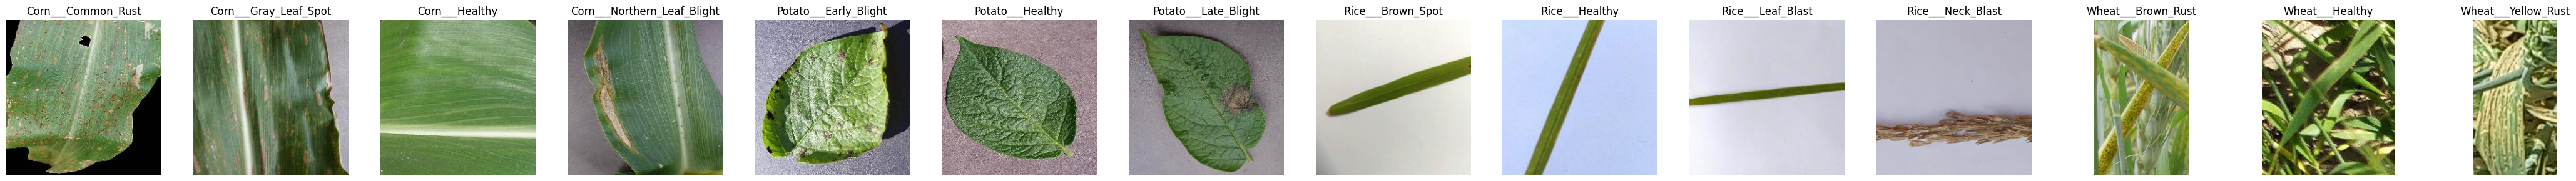

In [14]:
# Get class names (folder names)
class_names = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Prepare subplots
n_classes = len(class_names)
plt.figure(figsize=(n_classes * 3, 3))

for idx, class_name in enumerate(sorted(class_names)):
    class_folder = os.path.join(train_dir, class_name)
    # Get list of image files in this class
    img_files = [f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not img_files:
        continue  # skip if no images
    img_path = os.path.join(class_folder, img_files[0])  # Take the first image
    img = Image.open(img_path)
    plt.subplot(1, n_classes, idx + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

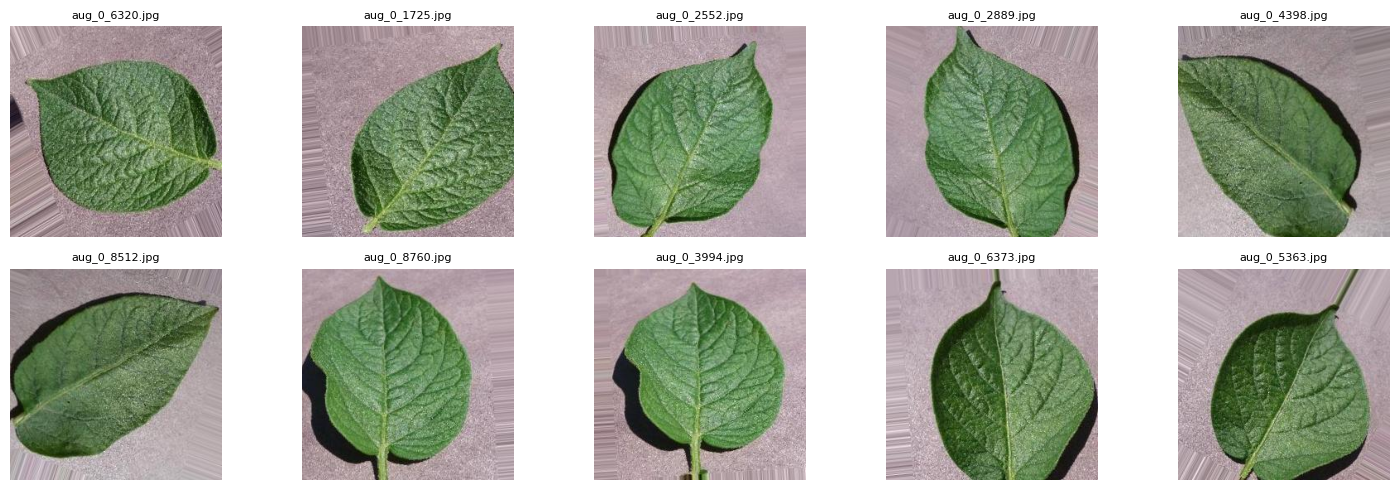

In [15]:
# Set the directory where your augmented images are stored
aug_dir = '/content/drive/My Drive/Colab Notebooks/Data/train/Potato___Healthy'  # change as needed

# Get all files starting with 'aug_' and ending with an image extension
aug_images = [f for f in os.listdir(aug_dir)
              if f.startswith('aug_') and f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Take the first 10
aug_images = aug_images[:10]

plt.figure(figsize=(15, 5))
for idx, img_name in enumerate(aug_images):
    img_path = os.path.join(aug_dir, img_name)
    img = Image.open(img_path)
    plt.subplot(2, 5, idx + 1)  # 2 rows, 5 columns
    plt.imshow(img)
    plt.title(img_name, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

Found 10653 images belonging to 14 classes.


In [17]:
input_shape = (224, 224, 3)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(
optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,632,014 (21.48 MB)

 Trainable params: 5,632,014 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
for i, layer in enumerate(model.layers):
    print(f"Layer {i+1}: {layer.name} ({layer.__class__.__name__})")


Layer 1: conv2d (Conv2D)
Layer 2: max_pooling2d (MaxPooling2D)
Layer 3: conv2d_1 (Conv2D)
Layer 4: max_pooling2d_1 (MaxPooling2D)
Layer 5: conv2d_2 (Conv2D)
Layer 6: max_pooling2d_2 (MaxPooling2D)
Layer 7: flatten (Flatten)
Layer 8: dense (Dense)
Layer 9: dense_1 (Dense)


In [19]:
callbacks = [
tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
tf.keras.callbacks.ModelCheckpoint('model.keras', save_best_only=True)  # can be saved via model.save too (see below)
]

In [ ]:
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=callbacks, #Optional
    class_weight=class_weight_dict  #Optional
)

Epoch 1/10
 83/333 ━━━━━━━━━━━━━━━━━━━━ 1:11:31 17s/step - accuracy: 0.5931 - loss: 1.1524